## Introduction<a id='introduction'></a>

**Purpose:**

Explore dataset to get a sense of which features are most predictive of EFS.

**Context:**

Hematopoietic stem cells, which reside in the bone marrow, are responsible for generating all blood cells, including red blood cells, platelet-producing cells, and immune system cells such as T cells, B cells, neutrophils, and natural killer cells. Allogeneic hematopoietic cell transplantation (HCT) can replace an individual's faulty hematopoietic stem cells with functional ones restoring healthy immune system function. 

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

The goal of the project is to predict an individual's risk score. (Target variable is ```efs```)

**Data:**

Project and data comes from [Kaggle](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/overview)

**Outcomes of Preprocessing:**

1. Removed rare occurences
2. Converted age to categories following prognostic factors identified from UpToDate
3. Binned Sorror comorbidity score
4. Target encoding led to minimal improvements in performance
5. Trained using efs, efs_time, and kaplan meier survival
    - efs produced best result, but could be model dependent

**Outcomes from this notebook (Training):**

1. Separately trained 4 models each using only risk data, patient data, donor/recipient data, and HCT data, then merged outputs into a multichannel NN
    - Validation Accuracy: 0.665
    - AUC: 0.719
    - EFS=0 predictions split into two groups, one that confidently predicts efs=0 and other that less confident
    - EFS=1 predictions appear as single distribution with long left-sided tail

## Contents<a id='contents'></a>
* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Setting Up Notebook](#setting_up_notebook)
    * [Loading Environment](#loading_environment)
    * [Loading and Cleaning Data](#loading_and_cleaning_data)
    * [Preprocessing and Helper Functions](#preprocessing_and_helper_functions)
* [Training a Multimodal Neural Network](#training_a_multimodal_neural_network)
    * [Risk Model](#risk_model)
    * [Risk and Patient Model](#risk_and_patient_model)
    * [Risk, Patient, and Donor/Recipient Model](#risk_patient_and_donorrecipient_model)
    * [Risk, Patient, Donor/Recipient, and HCT Model](#risk_patient_donorrecipient_and_hct_model)
    * [Fine-Tuning Model](#fine-tuning_model)
* [Summary](#summary)

## Objectives<a id='objectives'></a>

1. Preprocess data for training
2. Train models to predict EFS

## Setting Up Notebook <a id='setting_up_notebook'></a>

### Loading Environment<a id='loading_environment'></a>

In [1]:
from collections import defaultdict
import numpy as np
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 12, 'figure.figsize':(4,3)})

C:\Users\kimvo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter # may not be needed

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

### Loading and Cleaning Data<a id='loading_and_cleaning_data'></a>

In [3]:
def remove_rare_vals(df, threshold=0.01):
    '''
    Remove categorical values which appear less than the threshold frequency
    '''
    cols = df.columns.values
    threshold = int(df.shape[0]*threshold)

    new_df = pd.DataFrame()

    for col in cols:
        remove_vals = []
        for key, val in df[col].value_counts().to_dict().items():
            if val < threshold:
                remove_vals.append(key)

        new_series = []
        for x in df[col]:
            if x in remove_vals:
                new_series.append('NOT TESTED')
            else:
                new_series.append(x)

        new_df[col] = new_series

    return new_df

def categorize_age(my_arr):
    '''
    Bin age according to thresholds identified from UpToDate
    '''
    age_cat = []
    for x in my_arr:
        if pd.isna(x):
            age_cat.append('NOT TESTED')
        elif x < 1: # 6
            age_cat.append('Infant')
        elif x < 18: # 25
            age_cat.append('Child')
        elif x < 40: # 45
            age_cat.append('Young Adult')
        elif x < 65: # 65
            age_cat.append('Adult')
        else:
            age_cat.append('Senior')
    return age_cat

def bin_comorbidity(my_arr):
    '''
    Bin Sorror comorbidity according to bins identified from HCT-CI
    '''
    return [str(x) if x < 4 else '4' for x in my_arr]

def red_dri_score(df):
    '''
    Reduces the cardinality of dri_score by mapping values to one another based on similarity to target
    '''
    new_arr = []
    for val in df['dri_score']:
        if val == 'High':
            new_arr.append('High')
        elif val in ['High - TED AML case <missing cytogenetics', 'Intermediate', 'Intermediate - TED AML case <missing cytogenetics', 'Low']:
            new_arr.append('Intermediate')
        else:
            new_arr.append('Low')
    return new_arr

def te_feature_mean(df, col):
    '''
    Target encode feature using mean of kaplan meier survival function
    '''
    mapper = df[[col, 'y_km']].groupby(col).mean().to_dict()['y_km']
    return df[col].replace(mapper)

In [4]:
data = pd.read_csv('../data/interim/train.csv')

object_cols = list(data.columns[data.dtypes.values == 'O'])
num_cols = data.columns[(data.dtypes.values == 'int64') | (data.dtypes.values == 'float64')].drop(['Unnamed: 0', 'ID', 'year_hct'])

df = remove_rare_vals(data[object_cols])
df[num_cols] = data[num_cols]
df['age_at_hct_cat'] = categorize_age(data['age_at_hct'])
df['donor_age_cat'] = categorize_age(data['donor_age'])
df['binned_comorbidity'] = bin_comorbidity(data['comorbidity_score'])
df['donor-pt_age'] = df['donor_age'] - df['age_at_hct']

binary_cols = ['psych_disturb', 'diabetes', 'arrhythmia', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 
               'prior_tumor', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate']
for col in binary_cols:
    df[col] = df[col].str.replace('No', 'NOT TESTED')

df['ethnicity'] = df['ethnicity'].str.replace('Not Hispanic or Latino','NOT TESTED')
df['ethnicity'] = df['ethnicity'].str.replace('Non-resident of the U.S.','NOT TESTED')
df = df.drop(columns='peptic_ulcer')

km = KaplanMeierFitter()
km.fit(df['efs_time'], df['efs'])
df['y_km'] = km.survival_function_at_times(df['efs_time']).values

na = NelsonAalenFitter()
na.fit(durations=df['efs_time'], event_observed=df['efs'])
df['y_na'] = -na.cumulative_hazard_at_times(df['efs_time']).values

df['dri_score_red'] = red_dri_score(df)
df['te_dri_score'] = te_feature_mean(df, 'dri_score')
df['te_prim_disease_hct'] = te_feature_mean(df, 'prim_disease_hct')
df['te_gvhd_proph'] = te_feature_mean(df, 'gvhd_proph')

df['pt_sex'] = df['sex_match'].replace({'M-M':'M', 'F-M':'M', 'M-F':'F', 'F-F':'F'})
df['dr_sex_match'] = df['sex_match'].replace({'M-M':1, 'F-M':-1, 'M-F':-1, 'F-F':1, 'NOT TESTED':0})

C:\Users\kimvo\AppData\Local\Temp\ipykernel_20072\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].replace(mapper)
C:\Users\kimvo\AppData\Local\Temp\ipykernel_20072\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].replace(mapper)
C:\Users\kimvo\AppData\Local\Temp\ipykernel_20072\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)

### Preprocessing and Helper Functions<a id='preprocessing_and_helper_functions'></a>

In [5]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+s for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)

        X_cat = X_cat.drop(columns=X_cat.columns[pd.Series(X_cat.columns.values).str.contains('NOT TESTED')])

        return X_cat

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scaler = StandardScaler()
        X_num = pd.DataFrame(scaler.fit_transform(X[self.columns]), columns=self.columns)
        return X_num

In [6]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', SimpleImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

def preprocess_patient(df):
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'prim_disease_hct', 
                                                      'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'rheum_issue',
                                                      'race_group', 'hepatic_mild', 'cardiac', 'pulm_moderate'])),
            ('patient_num', NumericalTransformer(columns=['binned_comorbidity']))
        ]))
    ])

    df_trans = patient_pipe.fit_transform(df)

    cols = []
    transformers = ['patient_cat', 'patient_num']
    for trans in transformers:
        trans_cols = patient_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)
    
    return patient_pipe, pd.DataFrame(df_trans, columns=cols)

def preprocess_dr(df):
    dr_num_pipe = Pipeline([
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list())),
        ('impute_num', SimpleImputer()),
        ('pca_num', PCA(n_components=0.95, svd_solver='full'))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', dr_num_pipe)
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('impute', SimpleImputer())
    ])
    
    df_trans = dr_pipe.fit_transform(df)

    cols = dr_pipe['features']['dr_cat'].transform(df).columns.to_list()
    cols.extend(['pca_'+str(i) for i in range(1, dr_pipe['features']['dr_num'].transform(df).shape[1]+1)])

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return dr_pipe, df_trans

def preprocess_hct(df):
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'melphalan_dose', 'age_at_hct_cat', 'rituximab', 
                                                        'conditioning_intensity', 'donor_age_cat'])),
            ('hct_num', NumericalTransformer(columns=['te_gvhd_proph']))
        ]))
    ])

    df_trans = hct_pipe.fit_transform(df)

    transformers = ['hct_cat', 'hct_num']
    cols = []
    for trans in transformers:
        trans_cols = hct_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return hct_pipe, df_trans

def preprocess_X(x_train, x_test, processors):
    '''
    Wrapper function to process any combination of risk, patient, donor/recipient, and hct data
    Processors array-like containing function calls
    Returns list of training and testing data
    '''
    train_set = []
    test_set = []
    for p in processors:
        pipe, processedx_train = p(x_train)
        processedx_test = pd.DataFrame(pipe.transform(x_test), columns=processedx_train.columns)

        train_set.append(processedx_train)
        test_set.append(processedx_test)

    return train_set, test_set

In [7]:
def gen_r_model(riskx_train, n_fold):
    input_risk = keras.Input(shape=(riskx_train.shape[1],), name='risk_input')
    x = layers.Dense(riskx_train.shape[1],activation='relu', name='risk_dense1')(input_risk)
    # x = layers.BatchNormalization(name='risk_bn1')(x)
    # x = layers.Dropout(0.1, name='risk_dropout1')(x)
    x = layers.Dense(int(riskx_train.shape[1]/2), activation='relu', name='risk_dense2')(x)
    x = layers.Dropout(0.1, name='risk_dropout2')(x)
    x = layers.BatchNormalization(name='risk_bn2')(x)
    x = layers.Dense(4,activation='relu', name='risk_dense3')(x)
    output_risk = layers.Dense(1, activation='sigmoid', name='risk_out')(x)

    model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return model

def gen_rp_model(patientx_train, n_fold):
    patient_shape = patientx_train.shape[1]
    risk_model = keras.models.load_model('../models/risk_model_'+str(n_fold)+'fold.keras')
    risk_model.trainable = False

    input_patient = keras.Input(shape=(patient_shape,), name='patient_input')
    x = layers.Dense(patient_shape,activation='relu',name='patient_dense1')(input_patient)
    # x = layers.BatchNormalization(name='patient_bn1')(x)
    # x = layers.Dropout(0.1,name='patient_dropout1')(x)
    x = layers.Dense(int(patient_shape/2),activation='relu',name='patient_dense2')(x)
    x = layers.Dropout(0.1,name='patient_dropout2')(x)
    x = layers.BatchNormalization(name='patient_bn2')(x)
    x = layers.Dense(4,activation='relu',name='patient_dense3')(x)

    z = layers.Concatenate(axis=1, name='rp_concat')([risk_model.layers[-2].output, x])
    z = layers.BatchNormalization(name='rp_bn')(z)
    # z = layers.Dropout(0.1, name='rp_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rp_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rp_out')(z)

    ensemble_model = keras.Model(inputs=[risk_model.inputs, input_patient], outputs=output, 
                                 name='rp_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

def gen_rpd_model(drx_train, n_fold):
    dr_shape = drx_train.shape[1]
    rp_model = keras.models.load_model('../models/rp_model_'+str(n_fold)+'fold.keras')
    rp_model.trainable = False

    input_dr = keras.Input(shape=(dr_shape,), name='dr_input')
    x_dr = layers.Dense(dr_shape, activation='relu', name='dr_dense1')(input_dr)
    # x_dr = layers.BatchNormalization(name='dr_bn1')(x_dr)
    # x_dr = layers.Dropout(0.1,name='dr_dropout1')(x_dr)
    x_dr = layers.Dense(int(dr_shape/3),activation='relu',name='dr_dense2')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout2')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn2')(x_dr)
    x_dr = layers.Dense(4,activation='relu',name='dr_dense3')(x_dr)

    z = layers.Concatenate(axis=1, name='rpd_concat')([rp_model.layers[-4].output, x_dr])
    z = layers.BatchNormalization(name='rpd_bn')(z)
    # z = layers.Dropout(0.1, name='rpd_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpd_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpd_out')(z)

    ensemble_model = keras.Model(inputs=[rp_model.inputs, input_dr], outputs=output, 
                                 name='rpd_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

def gen_rpdh_model(hctx_train, n_fold):    
    hct_shape = hctx_train.shape[1]
    rpd_model = keras.models.load_model('../models/rpd_model_'+str(n_fold)+'fold.keras')
    rpd_model.trainable = False

    input_hct = keras.Input(shape=(hct_shape,), name='hct_input')
    x_hct = layers.Dense(hct_shape, activation='relu', name='hct_dense1')(input_hct)
    # x_hct = layers.BatchNormalization(name='hct_bn1')(x_hct)
    # x_hct = layers.Dropout(0.1,name='hct_dropout1')(x_hct)
    x_hct = layers.Dense(int(hct_shape/2), activation='relu', name='hct_dense2')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout2')(x_hct)
    x_hct = layers.BatchNormalization(name='hct_bn2')(x_hct)
    x_hct = layers.Dense(4, activation='relu', name='hct_dense3')(x_hct)

    z = layers.Concatenate(axis=1, name='rpdh_concat')([rpd_model.layers[-4].output, x_hct])
    z = layers.BatchNormalization(name='rpdh_bn')(z)
    # z = layers.Dropout(0.1, name='rpdh_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpdh_dense1')(z)
    # z = layers.BatchNormalization(name='rpdh_bn1')(z)
    # z = layers.Dropout(0.1, name='rpdh_dropout1')(z)
    # z = layers.Dense(4, activation='relu', name='rpdh_dense2')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpdh_out')(z)

    ensemble_model = keras.Model(inputs=[rpd_model.inputs, input_hct], outputs=output, 
                                 name='rpdh_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [8]:
def cross_validate(gen_model, processors, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='rpdh'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_scores = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocess_X(x_train, x_test, processors)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_scores[key] += history.history[key][-1]/n

    return pred, cv_scores

In [9]:
def trap_int(x, y):
    dx = x[1:]-x[:-1]
    mean_ys = (y[1:]+y[:-1])/2
    
    return sum(dx*mean_ys)

## Training a Multimodal Neural Network<a id='training_a_multimodal_neural_network'></a>

### Risk Model<a id='risk_model'></a>

In [10]:
pred, scores = cross_validate(gen_r_model, [preprocess_risk], df, df['efs'], save_model=True, name='risk')





Epoch 37: early stopping
180/180 [==============================] - 1s 4ms/step
Epoch 43: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 63: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 44: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 32: early stopping
180/180 [==============================] - 0s 2ms/step


In [11]:
scores

defaultdict(int,
            {'loss': 0.22711472511291503,
             'accuracy': 0.6281076431274414,
             'mse': 0.22711472511291503,
             'mae': 0.45407114624977113,
             'val_loss': 0.22771428823471068,
             'val_accuracy': 0.6276388883590699,
             'val_mse': 0.22771428823471068,
             'val_mae': 0.4560217618942261})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

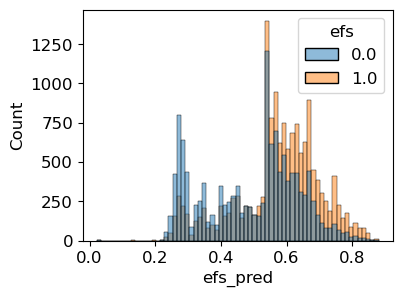

In [12]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.6622350350479898


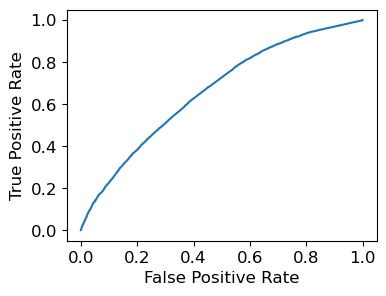

In [13]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', trap_int(fpr, tpr))

### Risk and Patient Model<a id='risk_and_patient_model'></a>

In [14]:
pred, scores = cross_validate(gen_rp_model, [preprocess_risk, preprocess_patient], df, df['efs'], save_model=True, name='rp')

Epoch 21: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 19: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 18: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 25: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 23: early stopping
180/180 [==============================] - 1s 2ms/step


In [15]:
scores

defaultdict(int,
            {'loss': 0.2151710867881775,
             'accuracy': 0.6562326312065124,
             'mse': 0.2151710867881775,
             'mae': 0.4301379323005677,
             'val_loss': 0.22260648310184478,
             'val_accuracy': 0.641527783870697,
             'val_mse': 0.22260648310184478,
             'val_mae': 0.4381578981876374})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

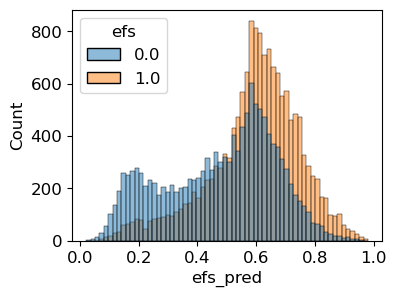

In [16]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.6804566065130415


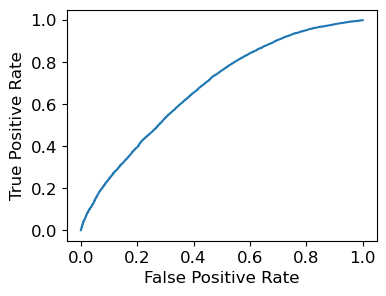

In [17]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', trap_int(fpr, tpr))

### Risk, Patient, and Donor/Recipient Model <a id='risk_patient_and_donorrecipient_model'></a>

In [18]:
pred, scores = cross_validate(gen_rpd_model, [preprocess_risk, preprocess_patient, preprocess_dr], df, df['efs'], save_model=True, name='rpd')

Epoch 26: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 31: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 27: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 28: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 32: early stopping
180/180 [==============================] - 1s 2ms/step


In [19]:
scores

defaultdict(int,
            {'loss': 0.20824485123157502,
             'accuracy': 0.6714062690734863,
             'mse': 0.20824485123157502,
             'mae': 0.41643663048744206,
             'val_loss': 0.21840436160564422,
             'val_accuracy': 0.6507638812065124,
             'val_mse': 0.21840436160564422,
             'val_mae': 0.427557373046875})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

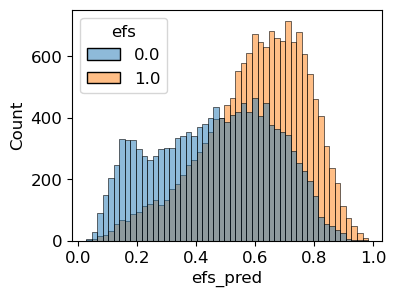

In [20]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.698506420677129


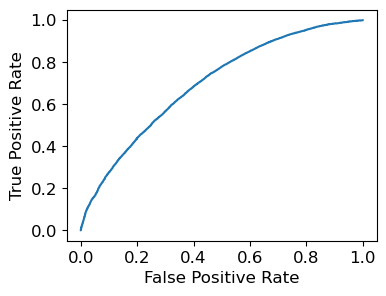

In [21]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', trap_int(fpr, tpr))

### Risk, Patient, Donor/Recipient, and HCT Model<a id='risk_patient_donorrecipient_and_hct_model'></a>

In [22]:
pred, scores = cross_validate(gen_rpdh_model, [preprocess_risk, preprocess_patient, preprocess_dr, preprocess_hct], df, df['efs'], save_model=True, name='rpdh')

Epoch 32: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 21: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 24: early stopping
180/180 [==============================] - 2s 7ms/step
Epoch 28: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 34: early stopping
180/180 [==============================] - 1s 2ms/step


In [23]:
scores

defaultdict(int,
            {'loss': 0.20147151052951812,
             'accuracy': 0.6876736044883728,
             'mse': 0.20147151052951812,
             'mae': 0.4026386380195618,
             'val_loss': 0.2121697187423706,
             'val_accuracy': 0.6619791626930236,
             'val_mse': 0.2121697187423706,
             'val_mae': 0.4149495303630829})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

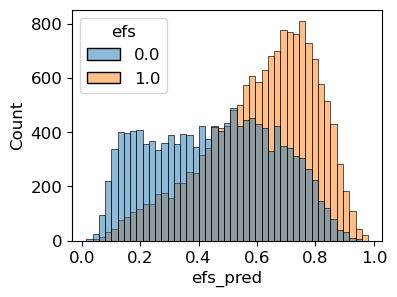

In [24]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.7195661110352405


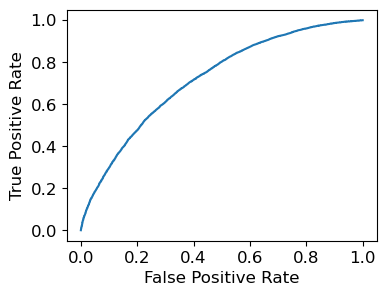

In [25]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', trap_int(fpr, tpr))

### Fine-Tuning Model<a id='fine-tuning_model'></a>

In [26]:
def tune_rpdh_model(n_fold, tuning_mode):
    rpdh_model = keras.models.load_model('../models/rpdh_model_'+str(n_fold)+'fold.keras')
    rpdh_model.trainable = False

    layers = [tuning_mode + i for i in ['_dense1', '_dense2', '_dense3', '_bn2']]
    for layer in layers:
        rpdh_model.get_layer(layer).trainable = True

    last_layers = ['rpdh' + i for i in ['_dense1', '_out', '_bn']]
    for layer in last_layers:
        rpdh_model.get_layer(layer).trainable = True

    return rpdh_model

In [27]:
def cv_tune_rpdh(tuning_mode, X, Y, n=5, shuffle=True, random_state=0, save_model=False):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_scores = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocess_X(x_train, x_test, [preprocess_risk, preprocess_patient, preprocess_dr, preprocess_hct])

        model = tune_rpdh_model(k, tuning_mode)
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/rpdh_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_scores[key] += history.history[key][-1]/n

    return pred, cv_scores

In [30]:
pred, scores = cv_tune_rpdh('patient', df, df['efs'], save_model=True)

Epoch 11: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 14: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 17: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 1s 2ms/step


In [31]:
scores

defaultdict(int,
            {'loss': 0.20066631734371185,
             'accuracy': 0.6894704818725585,
             'mse': 0.20066631734371185,
             'mae': 0.40129220485687256,
             'val_loss': 0.21248236298561096,
             'val_accuracy': 0.6652777671813965,
             'val_mse': 0.21248236298561096,
             'val_mae': 0.4137466728687286})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

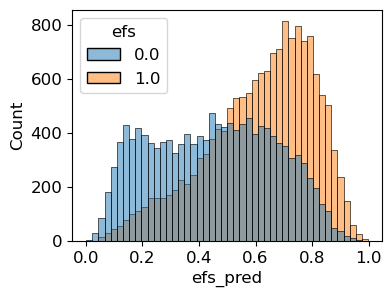

In [32]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.7190906588950814


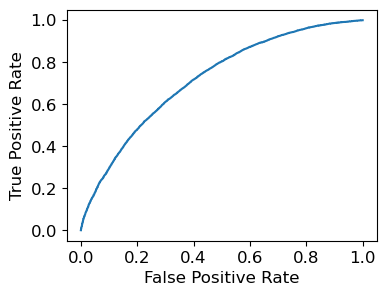

In [33]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', trap_int(fpr, tpr))

## Summary<a id='summary'></a>

1. Each channel (risk, patient, donor/recipient, HCT) improved model accuracy and AUC
2. Validation accuracy was unexpectedly low at 0.665
3. AUC was 0.719
4. efs=0 predictions were split into two groups, one that was centered at ~0.13 and confidently predicted efs=0, while the other was centered at 0.5 and did not confidently predict efs=0
5. efs=1 predictions followed a single distribution with a long left-sided tail. Peak at ~0.76